# Imports

In [3]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Read Data

In [183]:
df = pd.read_csv('../02_analysis/df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_60187/882331396.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


In [184]:
# Convert 'trial_date' to datetime and sort the dataframe
df['trial_date'] = pd.to_datetime(df['trial_date'])
df_sorted = df.sort_values(by=['PID', 'trial_date'])

# Baseline Model

## Data Munge

In [ ]:
# Create shifted columns
df['sr_gap_heuristic_d1'] = df.groupby('PID')['sr_gap_heuristic'].shift(-1)
df['sr_gap_heuristic_d2'] = df.groupby('PID')['sr_gap_heuristic'].shift(-2)
df['sr_gap_heuristic_d3'] = df.groupby('PID')['sr_gap_heuristic'].shift(-3)

In [290]:
cols = [col for col in df.columns if 'heuristic' in col]
cols

['sr_gap_heuristic',
 'sr_gap_heuristic_residual',
 'sr_gap_heuristic_intercept',
 'sr_gap_heuristic_slope',
 'sr_gap_heuristic_d1',
 'sr_gap_heuristic_d2',
 'sr_gap_heuristic_d3']

In [6]:
df[cols]

,sr_gap_heuristic,sr_gap_heuristic_residual,sr_gap_heuristic_intercept,sr_gap_heuristic_slope,sr_gap_heuristic_d1,sr_gap_heuristic_d2,sr_gap_heuristic_d3
0,5.00,-12.693303,17.753776,-0.060473,15.25,46.35,43.70
1,15.25,-2.382829,17.753776,-0.060473,46.35,43.70,45.60
2,46.35,28.777644,17.753776,-0.060473,43.70,45.60,11.55
3,43.70,26.188117,17.753776,-0.060473,45.60,11.55,4.10
4,45.60,28.148591,17.753776,-0.060473,11.55,4.10,17.35
...,...,...,...,...,...,...,...
8920,58.05,16.075780,47.125900,-0.063601,26.25,67.35,52.15
8921,26.25,-15.660619,47.125900,-0.063601,67.35,52.15,NaN
8922,67.35,25.502982,47.125900,-0.063601,52.15,NaN,NaN
8923,52.15,10.366583,47.125900,-0.063601,NaN,NaN,NaN


## RMSE

In [7]:
# Define a function to calculate MSE for a specific lag
def calculate_mse(data, actual, predicted):
    data = data.dropna(subset=[actual, predicted])  # Ensure no NaN values
    rmse = np.sqrt(mean_squared_error(data[actual], data[predicted]))
    return rmse

# Group by 'PID' and apply the MSE calculation for each prediction day
rmse_results = df.groupby('PID').apply(lambda x: pd.Series({
    'RMSE_Day_1': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d1'),
    'RMSE_Day_2': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d2'),
    'RMSE_Day_3': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d3')
})).reset_index()

In [8]:
rmse_results

,PID,RMSE_Day_1,RMSE_Day_2,RMSE_Day_3
0,0151d9f1-1644-4437-805e-02f5e244a690,12.484630,14.869927,14.895803
1,02f48bee-6e86-437c-9394-10ae57dadd14,26.379210,24.527410,25.394194
2,0501ba67-3406-4779-aff1-878a0e9f7885,26.945275,30.797342,32.152243
3,06af7782-cd70-4938-8e67-b6d98b34b665,14.664723,14.417367,18.015907
4,075f7c4e-edea-4d64-8844-f046a1beb770,18.910780,21.273065,19.474681
...,...,...,...,...
100,fb6c8f5a-f92d-4af8-9f87-73ffd4e21f98,24.921687,28.546079,28.667586
101,fc490430-6a41-4853-a2cf-ae0b15265cb6,24.212830,25.429221,26.734689
102,fed3a16b-c5a3-4a84-a111-32b7574e04b5,9.655825,9.885494,8.897692
103,fee5cd07-329a-4f07-bb1a-913dfa09e3b4,19.245491,20.687113,20.787086


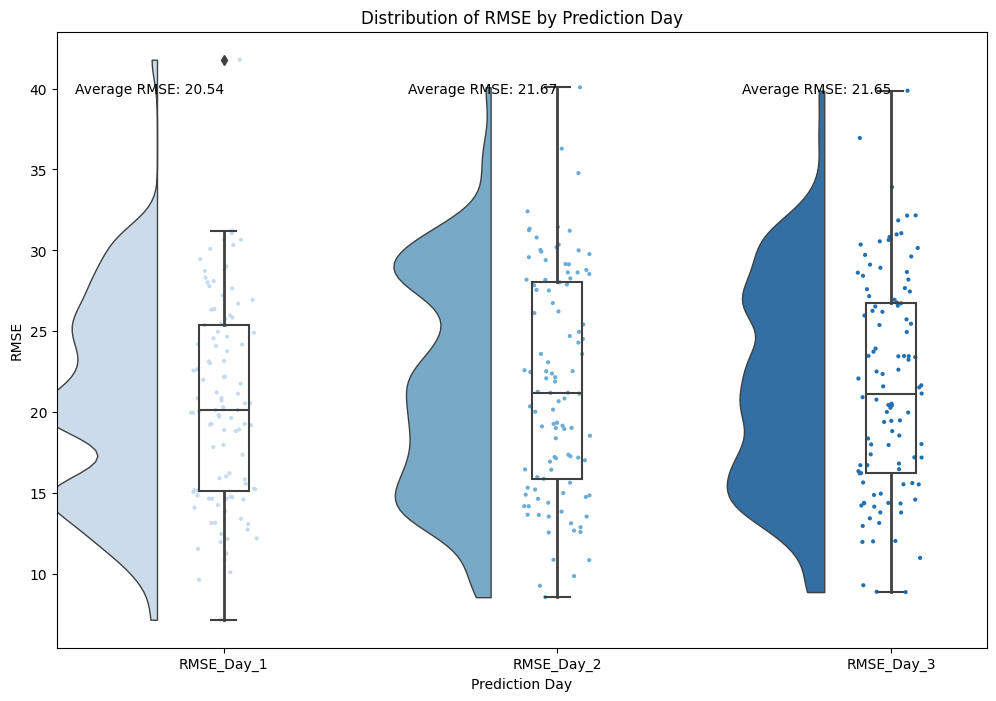

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt

# Melting the dataframe for suitable plotting
plot_data = rmse_results.melt(id_vars=['PID'], var_name='Prediction_Day', value_name='RMSE')

# Calculate average MSE for each day
average_mse = plot_data.groupby('Prediction_Day')['RMSE'].mean().reset_index()
average_mse['label'] = average_mse['RMSE'].apply(lambda x: f'Average RMSE: {x:.2f}')

# Creating a raincloud plot
plt.figure(figsize=(12, 8))
ax = pt.RainCloud(data=plot_data, x='Prediction_Day', y='RMSE', palette='Blues', bw=0.2)

# Title and labels
plt.title('Distribution of RMSE by Prediction Day')
plt.xlabel('Prediction Day')
plt.ylabel('RMSE')

# Adding average MSE labels to the plot
for i, row in average_mse.iterrows():
    plt.text(x=i, y=plot_data['RMSE'].max() * .95, s=row['label'], horizontalalignment='right')

plt.show()

## Correlation

In [10]:
from scipy.stats import pearsonr

def calculate_correlation(data, actual, predicted):
    valid_data = data.dropna(subset=[actual, predicted])
    if len(valid_data) < 2:
        return np.nan  # Return NaN if not enough data to calculate correlation
    correlation, _ = pearsonr(valid_data[actual], valid_data[predicted])
    return correlation

# Group by 'PID' and apply the correlation calculation for each prediction day
correlation_results = df.groupby('PID').apply(lambda x: pd.Series({
    'Correlation_Day_1': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d1'),
    'Correlation_Day_2': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d2'),
    'Correlation_Day_3': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d3')
})).reset_index()

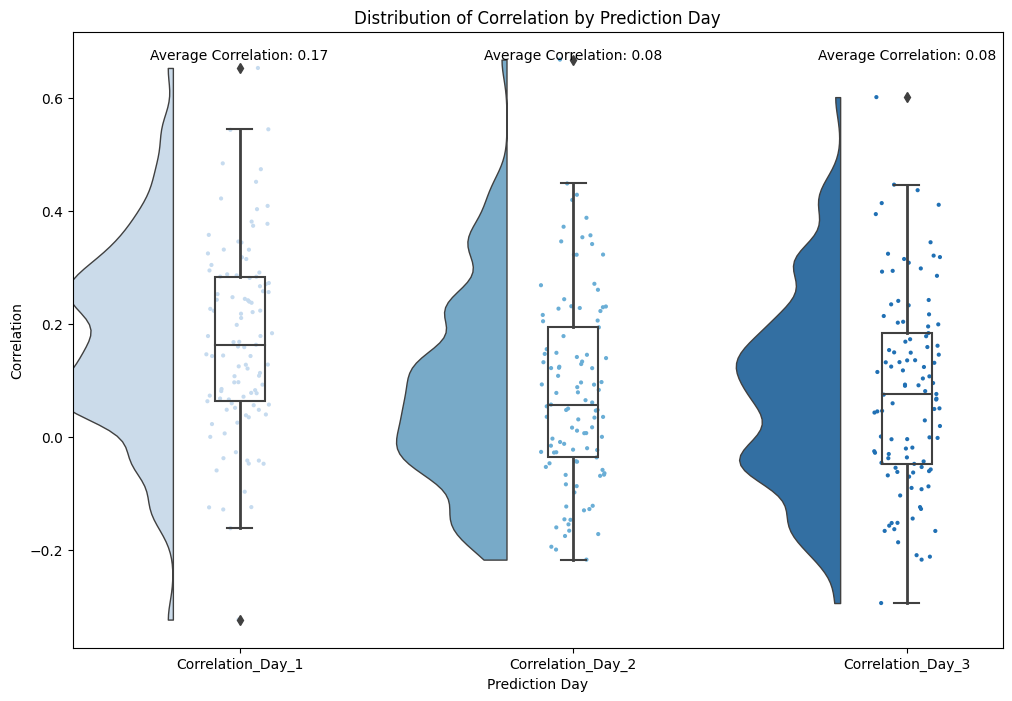

In [11]:
# Melting the dataframe for suitable plotting
plot_data = correlation_results.melt(id_vars=['PID'], var_name='Prediction_Day', value_name='Correlation')

# Calculate average correlation for each day
average_corr = plot_data.groupby('Prediction_Day')['Correlation'].mean().reset_index()
average_corr['label'] = average_corr['Correlation'].apply(lambda x: f'Average Correlation: {x:.2f}')

# Creating a raincloud plot
plt.figure(figsize=(12, 8))
ax = pt.RainCloud(data=plot_data, x='Prediction_Day', y='Correlation', palette='Blues', bw=0.2)

# Title and labels
plt.title('Distribution of Correlation by Prediction Day')
plt.xlabel('Prediction Day')
plt.ylabel('Correlation')

# Adding average correlation labels to the plot
for i, row in average_corr.iterrows():
    plt.text(x=i, y=plot_data['Correlation'].max(), s=row['label'], horizontalalignment='center')

plt.show()

# Mixed Effects Models

## Gap

In [12]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

results = {}
pred_columns = ['sr_gap_heuristic_d1', 'sr_gap_heuristic_d2', 'sr_gap_heuristic_d3']
for col in pred_columns:
    model = MixedLM(df_pred[col], df_pred[['sr_gap_heuristic']], groups=df_pred['PID'])
    result = model.fit()
    df_pred[col + '_pred'] = result.fittedvalues  # Store predictions for RMSE calculation
    results[col] = result

# Output the summary of one of the models if needed
print(results['sr_gap_heuristic_d1'].summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic_d1
No. Observations: 6988    Method:             REML               
No. Groups:       105     Scale:              268.4983           
Min. group size:  21      Log-Likelihood:     -29758.8843        
Max. group size:  81      Converged:          Yes                
Mean group size:  66.6                                           
-----------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
sr_gap_heuristic        0.197    0.012 16.561 0.000  0.174  0.220
Group Var            1233.337   10.744                           



In [13]:
rmse_scores = {}
for col in pred_columns:
    actual = df_pred[col].dropna()
    predicted = df_pred[col + '_pred'][actual.index]  # Ensure alignment of indices
    mse = mean_squared_error(actual, predicted)
    rmse_scores[col] = np.sqrt(mse)

# Display the RMSE scores
print(rmse_scores)

{'sr_gap_heuristic_d1': 16.261564564708788, 'sr_gap_heuristic_d2': 16.48465638065982, 'sr_gap_heuristic_d3': 16.33214734067258}


## Gap + Net Affect

In [14]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3',
        'sr_affect_net_avg'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

results = {}
pred_columns = ['sr_gap_heuristic_d1', 'sr_gap_heuristic_d2', 'sr_gap_heuristic_d3']
for col in pred_columns:
    model = MixedLM(df_pred[col], df_pred[['sr_gap_heuristic', 'sr_affect_net_avg']], groups=df_pred['PID'])
    result = model.fit()
    df_pred[col + '_pred'] = result.fittedvalues  # Store predictions for RMSE calculation
    results[col] = result

# Output the summary of one of the models if needed
print(results['sr_gap_heuristic_d1'].summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic_d1
No. Observations: 6823    Method:             REML               
No. Groups:       105     Scale:              267.8141           
Min. group size:  16      Log-Likelihood:     -29051.1780        
Max. group size:  81      Converged:          Yes                
Mean group size:  65.0                                           
-----------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
sr_gap_heuristic        0.210    0.013 16.663 0.000  0.186  0.235
sr_affect_net_avg       0.573    0.245  2.340 0.019  0.093  1.053
Group Var            1189.945   10.440                           



In [15]:
rmse_scores = {}
for col in pred_columns:
    actual = df_pred[col].dropna()
    predicted = df_pred[col + '_pred'][actual.index]  # Ensure alignment of indices
    mse = mean_squared_error(actual, predicted)
    rmse_scores[col] = np.sqrt(mse)

# Display the RMSE scores
print(rmse_scores)

{'sr_gap_heuristic_d1': 16.236674085423978, 'sr_gap_heuristic_d2': 16.488029222619012, 'sr_gap_heuristic_d3': 16.273360147514058}


# ML Models

### Feature Engineering

In [16]:
# Example feature engineering: Mean encoding for PIDs
pid_mean = df.groupby('PID')['sr_gap_heuristic'].transform('mean')
df['sr_gap_heuristic_mean'] = pid_mean

pid_mean = df.groupby('PID')['sr_affect_net_avg'].transform('mean')
df['sr_affect_subject_mean'] = pid_mean

df['sr_gap_heuristic_residual'] = df['sr_gap_heuristic'] - df['sr_gap_heuristic_mean']
df['sr_affect_residual'] = df['sr_affect_net_avg'] - df['sr_affect_subject_mean']

In [18]:
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3',
        'sr_affect_net_avg',
        'sr_gap_heuristic_mean',
        'sr_gap_heuristic_residual',
        'sr_affect_subject_mean',
        'sr_affect_residual'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

## Gradient Boosted | Affect + Gap

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 6
[LightGBM] [Info] Start training from score 42.923862
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 15.6652	valid_0's l2: 245.399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number of data points in the train set: 5457, number of used features: 6
[LightGBM] [Info] Start training from score 41.638802
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 17.2657	valid_0's l2: 298.103
[LightGBM] [Info] Auto-c

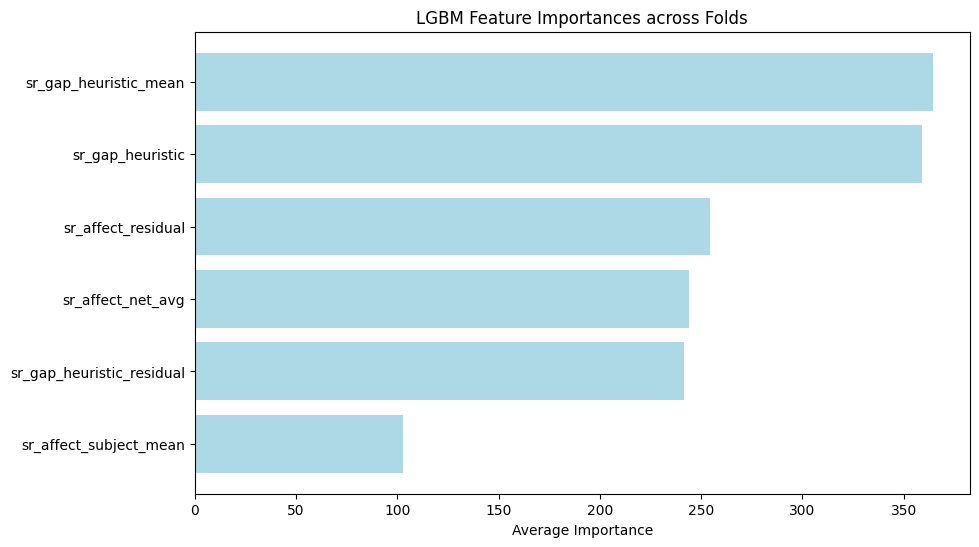

In [23]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from lightgbm.callback import early_stopping

# Prepare features and target
X = df_pred[['sr_gap_heuristic', 'sr_affect_net_avg', 'sr_gap_heuristic_mean', 'sr_gap_heuristic_residual', 'sr_affect_subject_mean', 'sr_affect_residual']]  # plus other features as needed
y = df_pred['sr_gap_heuristic_d1']  # Predicting Day 1 gap as an example
groups = df_pred['PID']

# Setup Group K-Fold to respect PID groups
gkf = GroupKFold(n_splits=5)

# Define the model
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)

# Prepare to store feature importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

rmse_scores = []

# Perform group k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[early_stopping(10)]
    )
    
    # Use the best iteration to make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    
    # Calculate RMSE and append to list
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    # Get feature importances
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold + 1
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)


# Output the RMSE scores
print("RMSE scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

# Compute average feature importances across all folds
average_importances = feature_importances.groupby('feature').mean().sort_values(by="importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title('LGBM Feature Importances across Folds')
plt.barh(average_importances.index, average_importances['importance'], color='lightblue')
plt.xlabel('Average Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

## Same Day

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 4
[LightGBM] [Info] Start training from score 42.960721
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 15.2621	valid_0's l2: 232.933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 5457, number of used features: 4
[LightGBM] [Info] Start training from score 41.624255
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's rmse: 17.0831	valid_0's l2: 291.832
[LightGBM] [Info] Auto-cho

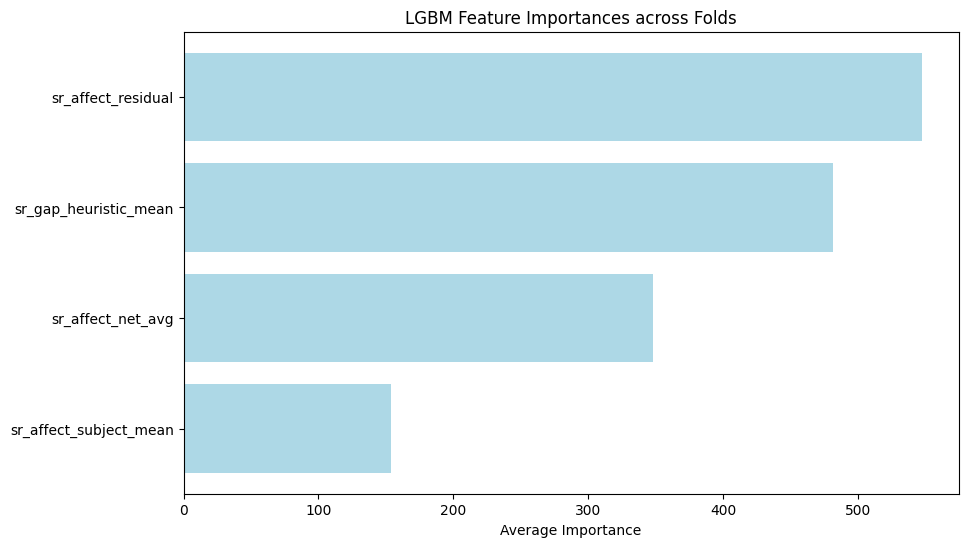

In [26]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from lightgbm.callback import early_stopping

# Prepare features and target
X = df_pred[['sr_affect_net_avg', 'sr_gap_heuristic_mean', 'sr_affect_subject_mean', 'sr_affect_residual']]  # plus other features as needed
y = df_pred['sr_gap_heuristic']  # Predicting Day 1 gap as an example
groups = df_pred['PID']

# Setup Group K-Fold to respect PID groups
gkf = GroupKFold(n_splits=5)

# Define the model
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)

# Prepare to store feature importances
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

rmse_scores = []

# Perform group k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[early_stopping(10)]
    )
    
    # Use the best iteration to make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    
    # Calculate RMSE and append to list
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    # Get feature importances
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold + 1
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)


# Output the RMSE scores
print("RMSE scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

# Compute average feature importances across all folds
average_importances = feature_importances.groupby('feature').mean().sort_values(by="importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.title('LGBM Feature Importances across Folds')
plt.barh(average_importances.index, average_importances['importance'], color='lightblue')
plt.xlabel('Average Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

## Location

- Fix timing
- Look at raw data

## Weekly Effects
- mimic the paper Cendri sent?

# Select Subject

In [186]:
sub = 1

subject = np.unique(df.PID)[sub-1]

print(f'Subject {subject} selected.')

Subject 0151d9f1-1644-4437-805e-02f5e244a690 selected.


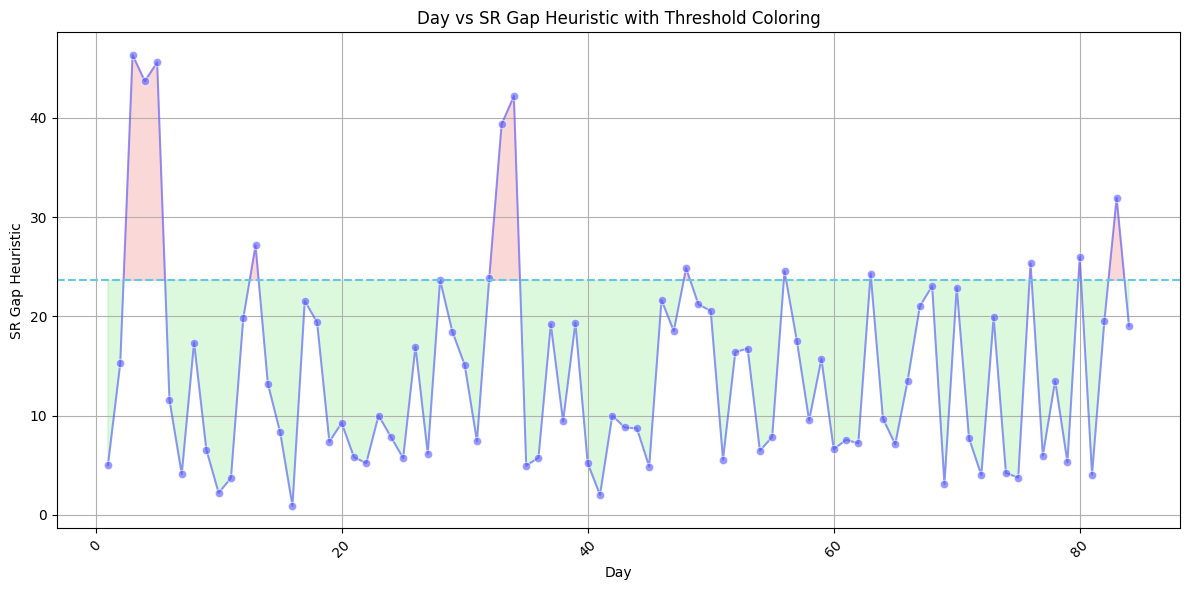

In [187]:
df_sub = df.loc[df.PID == subject]

# Calculate the midpoint value between max and min of sr_gap_heuristic
max_val = df_sub['sr_gap_heuristic'].max()
min_val = df_sub['sr_gap_heuristic'].min()
mid_val = (max_val + min_val) / 2

# Creating the plot
plt.figure(figsize=(12, 6))
# Plotting all data points
sns.lineplot(x='day', y='sr_gap_heuristic', data=df_sub, color="#5356FF", alpha=0.6, marker='o')

# Add a horizontal line at the threshold
plt.axhline(y=mid_val, color='#67C6E3', linestyle='--')
plt.fill_between(df_sub['day'], df_sub['sr_gap_heuristic'], mid_val, where=(df_sub['sr_gap_heuristic'] <= mid_val), 
                 interpolate=True, color='lightgreen', alpha=0.3)
plt.fill_between(df_sub['day'], df_sub['sr_gap_heuristic'], mid_val, where=(df_sub['sr_gap_heuristic'] > mid_val), 
                 interpolate=True, color='lightcoral', alpha=0.3)

plt.title('Day vs SR Gap Heuristic with Threshold Coloring')
plt.xlabel('Day')
plt.ylabel('SR Gap Heuristic')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Cleaning

In [191]:
# Convert all columns to numeric, setting errors='coerce' will convert non-convertible values to NaN
df_numeric = df.loc[df.PID == subject].apply(pd.to_numeric, errors='coerce')

In [192]:
X = df_numeric.copy()

### Extract Categorical Features

In [193]:
cat_cols = ['day_of_week', 'task_nback_mode']
X.drop(columns=cat_cols, inplace=True)

### Remove Extraneous Features

In [194]:
# Remove app/web columns for device usage as these are then totaled
web_cols = [col for col in X.columns if 'passive_sk_device_web_usage' in col]
app_cols = [col for col in X.columns if 'passive_sk_device_app_usage' in col]

X.drop(columns=web_cols, inplace=True)
X.drop(columns=app_cols, inplace=True)

In [195]:
# Remove trial date - using day
X.drop(columns='trial_date', inplace=True)

In [210]:
X.shape

(85, 408)

In [204]:
# remove existing residual columns since we will be calculating differences/residuals for all columns
cols = [col for col in X.columns if 'residual' in col]
X.drop(columns=cols, inplace=True)

In [205]:
# z scored some rts, can remove those
cols = [col for col in X.columns if 'rt_z' in col]
X.drop(columns=cols, inplace=True)

In [206]:
# remove keyboard sentiment for emoji and word individually since they are combined
cols = [col for col in X.columns if 'keyboard_sentiment_emoji' in col]
X.drop(columns=cols, inplace=True)

In [207]:
# remove keyboard sentiment for emoji and word individually since they are combined
cols = [col for col in X.columns if 'keyboard_sentiment_word' in col]
X.drop(columns=cols, inplace=True)

In [208]:
# remove device sentiment as this is an error
cols = [col for col in X.columns if 'device_sentiment' in col]
X.drop(columns=cols, inplace=True)

In [209]:
# Remove heuristic gap components
heuristic_gap_cols = ['sr_DAILY_past24_gap', 'sr_DAILY_goal1_report', 'sr_DAILY_goal2_report', 'sr_DAILY_past24_values']

X.drop(columns=heuristic_gap_cols, inplace=True)

# Remove simple gap which is just sr_DAILY_past24_gap
X.drop(columns='sr_gap_simple', inplace=True)

KeyError: "['sr_DAILY_past24_gap', 'sr_DAILY_goal1_report', 'sr_DAILY_goal2_report', 'sr_DAILY_past24_values'] not found in axis"

### Remove Features Over NA Threshold

In [169]:
# Remove columns with NaN counts about threshold
threshold_nan = 0.5

nan_counts = X.isna().sum()
cols_to_drop_due_to_nans = nan_counts[nan_counts > len(X) * threshold_nan].index
X = X.drop(columns=cols_to_drop_due_to_nans)

print(f'Removed {len(cols_to_drop_due_to_nans)} features due to NaNs:\n')
for item in cols_to_drop_due_to_nans:
    print(item)

Removed 99 features due to NaNs:

PID
affect_pct_zeroVarRows
affect_zeroVarRows_flag
sr_DAILY_goal1_interaction_month
sr_DAILY_goal1_interaction_week
sr_DAILY_goal1_set
sr_DAILY_goal2_interaction_month
sr_DAILY_goal2_interaction_week
sr_DAILY_goal2_set
sr_DAILY_next24_drinks
sr_DAILY_next24_leisureNonSolo
sr_DAILY_next24_leisureSolo
sr_DAILY_next24_nonoccupation
sr_DAILY_next24_socialMedia
sr_DAILY_past24_diet
sr_DAILY_past24_gapCause
sr_DAILY_past48to24_gap
sr_DAILY_past48to24_gapCause
sr_DAILY_survey_missed
sr_DAILY_survey_situation1_surveys
sr_DAILY_survey_situation2_surveys
sr_IDEAL_values_monthly1
sr_IDEAL_values_monthly2
sr_IDEAL_values_monthly3
sr_MONTHLY_goal_set1
sr_MONTHLY_goal_set2
sr_WEEKLY_goal_set1
sr_WEEKLY_goal_set2
sr_DAILY_past48to24_gapCause_internal
sr_DAILY_past48to24_gapCause_external
sr_DAILY_gap_diet
sr_DAILY_gap_nonoccupation
sr_DAILY_gap_leisureSolo
sr_DAILY_gap_leisureNonSolo
sr_DAILY_gap_socialMedia
sr_DAILY_gap_drinks
task_motivation_time
task_gng_time
task

In [170]:
# Remove columns with almost no variance

# First scale using Min-Max Normalization
X = (X-X.min())/(X.max()-X.min())

# Set threshold
var_threshold = .01

no_var_cols = X.loc[:, np.var(X) <= var_threshold].columns
## X = X.loc[:, np.var(X) > var_threshold]

print(f'\nRemoved {len(no_var_cols)} features due to Var <= {var_threshold}:\n')
for item in no_var_cols:
    print(item)


Removed 0 features due to Var <= 0.01:



In [171]:
# if the max and min value were the same var = NaN...remove these

nan_counts = X.isna().sum()
cols_to_drop_due_to_nans = nan_counts[nan_counts > len(X) * threshold_nan].index
X = X.drop(columns=cols_to_drop_due_to_nans)

print(f'Removed {len(cols_to_drop_due_to_nans)} features due to NaNs:\n')
for item in cols_to_drop_due_to_nans:
    print(item)

Removed 55 features due to NaNs:

affect_neg_lonelyIsolated_am
affect_zeroVar_cols
affect_zeroVarCols_flag
sr_DAILY_past24_drinks
sr_DAILY_past24_leisureSoloPhysical
sr_dailySR_zeroVar_cols
sr_dailySR_zeroVarCols_flag
task_nback_trialCount
task_psat_flag_sub100RT_n
task_psat_flag_3plusRT_n
task_hanoi_solved
task_rt_flag_plus2_n
passive_sk_visits_home_distance
passive_sk_visits_gym_elapsed
passive_sk_visits_school_elapsed
passive_sk_visits_unknown_distance_flag
task_hanoi_movesTime_model_startPoint
task_hanoi_movesTime_model_decay
task_hanoi_movesTime_model_asymptote
task_psat_effciency_model_intercept
task_psat_effciency_model_slope
task_stroop_effciency_model_intercept
task_stroop_effciency_model_slope
task_bart_score_model_intercept
task_bart_score_model_slope
task_spatialSpan_score_model_intercept
task_spatialSpan_score_model_slope
task_emoStroop_trying
task_emoStroop_efficiency_model_intercept
task_emoStroop_efficiency_model_slope
task_gng_trying
task_gng_d_prime_model_intercept
ta

In [172]:
X.shape

(85, 254)

### Remove Features Over Correlation Threshold

**Notes**

> in `.corr()` Pearson, Kendall and Spearman correlation are currently computed using pairwise complete observations.

> in `.corr()` the `min_periods` parameter indicates the minimum number of observations required per pair of columns to have a valid result.

In [173]:
# Compute the correlation matrix - need at least 20 values
corr_matrix = X.corr(method='pearson', min_periods=20).abs()

In [174]:
# there are some nan columns as the min 20 periods do not line up for all variables...
corr_matrix.isna().sum().sum()

44

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


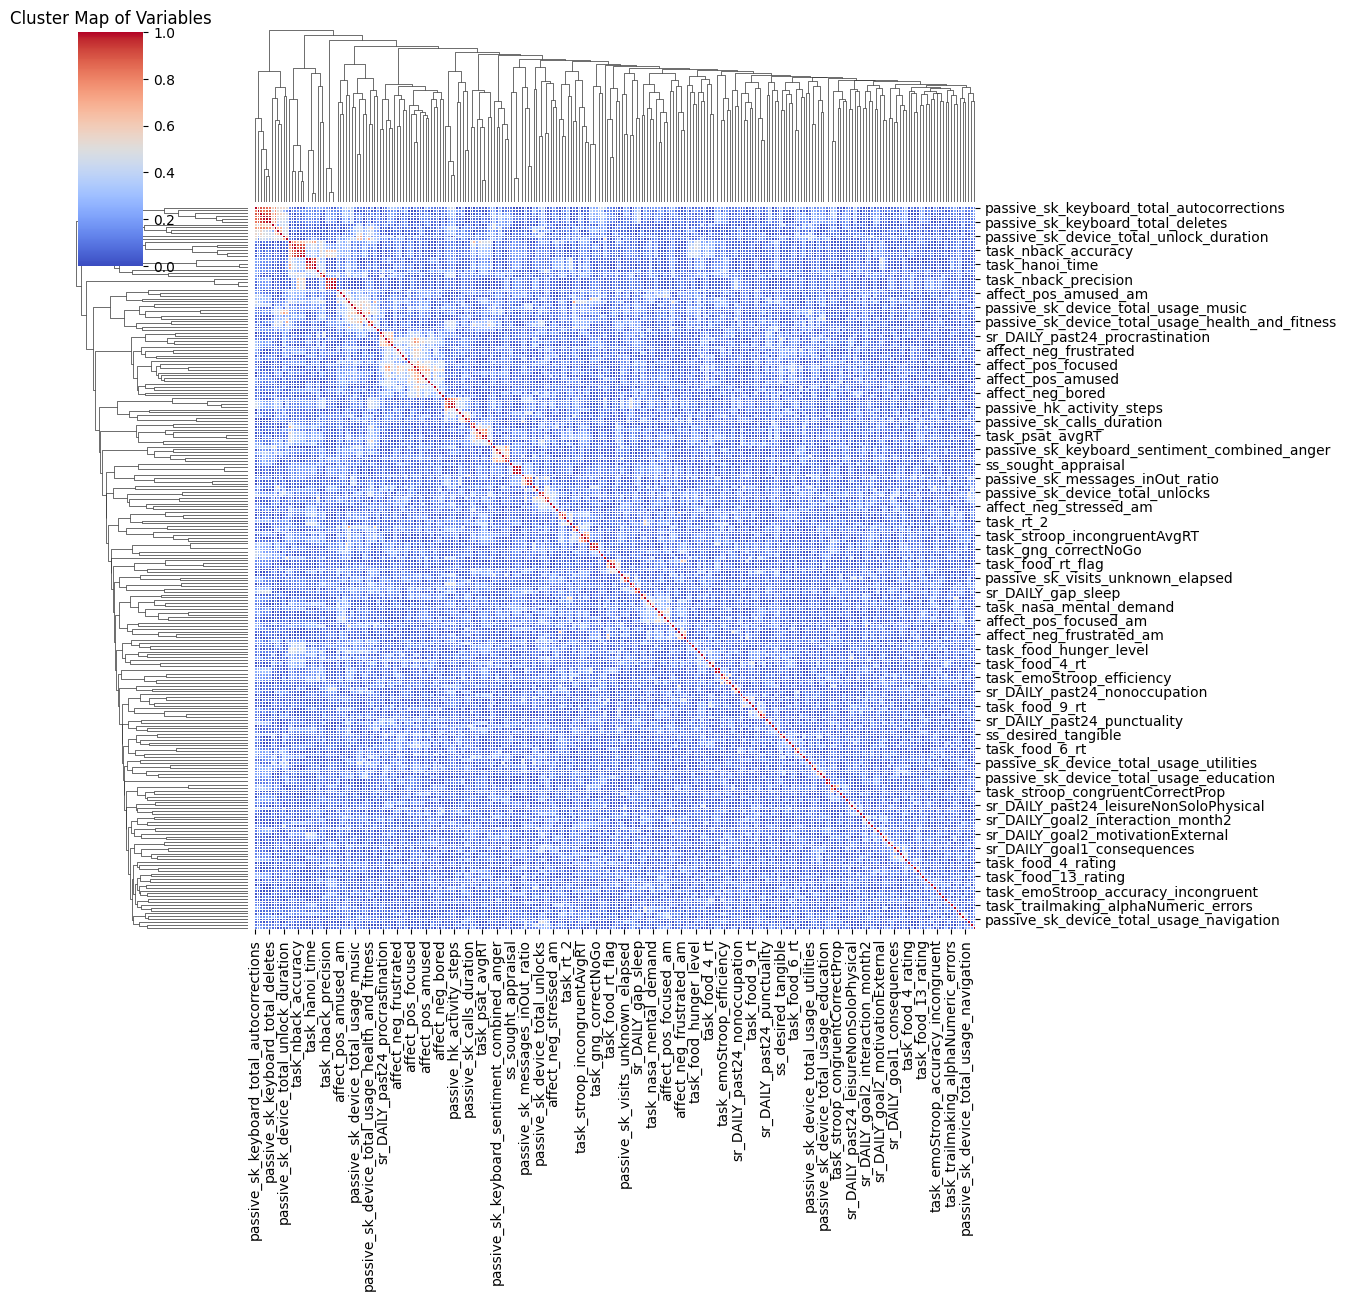

In [115]:
# fill Na values in corr matrix
corr_matrix = corr_matrix.fillna(0)

sns.clustermap(corr_matrix, figsize=(13, 13), cmap='coolwarm', linewidths=.5)
plt.title('Cluster Map of Variables')
plt.show()

In [175]:
# Define the threshold
threshold = 0.95

# Create a mask to find correlations greater than the threshold, ignoring the diagonal
mask = abs(corr_matrix) > threshold
np.fill_diagonal(mask.values, False)

# Extract pairs above threshold
high_corr_pairs = corr_matrix[mask].stack()

# Format the output for better readability
formatted_pairs = pd.DataFrame(high_corr_pairs).reset_index()
formatted_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
formatted_pairs = formatted_pairs.drop_duplicates(subset=['Correlation'])

formatted_pairs #.sort_values(by='Correlation', ascending=False)

,Variable 1,Variable 2,Correlation
0,sr_DAILY_past24_gapCause_internal,sr_DAILY_past24_gapCause_external,1.000000
6,task_bart_total_pumps,task_bart_unpopped_n,0.984944
9,task_bart_unpopped_n,task_bart_score,0.984944
12,task_nback_missed,task_nback_recall,0.955860
13,task_nback_falseAlarm,task_nback_precision,0.953496
14,task_nback_falseAlarm,task_nback_specificity,0.994314
15,task_nback_falseAlarm,task_nback_falseAlarmRate,0.994314
16,task_nback_accuracy,task_nback_MCC,0.973813
19,task_nback_recall,task_nback_F1,0.953046
21,task_nback_specificity,task_nback_falseAlarmRate,1.000000


In [176]:
# Identify pairs of highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

In [177]:
to_drop

['sr_DAILY_past24_gapCause_external',
 'task_gng_correctGo',
 'task_gng_correctNoGo',
 'task_bart_unpopped_n',
 'task_bart_score',
 'task_nback_precision',
 'task_nback_recall',
 'task_nback_specificity',
 'task_nback_falseAlarmRate',
 'task_nback_F1',
 'task_nback_MCC',
 'task_hanoi_extraMoves',
 'passive_hk_activity_steps',
 'passive_sk_keyboard_total_typing_duration',
 'passive_sk_keyboard_total_deletes',
 'task_hanoi_movesTime',
 'task_psat_efficiency']

In [178]:
# Drop highly correlated columns
X = X.drop(to_drop, axis=1)

In [179]:
X.shape

(85, 237)

# Feature Engineering
- window stats (e.g. 3 day, 7 day)
    - mean, SD, min, max
- `delta` features
    - day to day differences
    - day to week

### Rolling Average, Lags and Diffs

For each column calculate:

- 3 and 7 day rolling average (up to current day)
- Expanding average (1st day to current day)
- 7 day variance (up to current day)
- 1, 2 and 3 day lags of each feature
- Difference between 3, 7 and expanding average and current day

In [121]:
# Get numeric columns only for processing
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Dictionary to hold new columns
new_columns = {}

# Calculate rolling averages and store in the dictionary
for col in numeric_cols:
    for window in [3, 7]:
        rolling_col = X[col].rolling(window=window, min_periods=1).mean()  # use min_periods=1 to ensure output
        new_columns[f'{col}_rolling_mean_{window}'] = rolling_col
        new_columns[f'{col}_exponential_rolling_mean_{window}'] = X[col].ewm(span=window).mean()

# Calculate rolling mean including the current row for each numeric column
for col in numeric_cols:
    new_columns[f'{col}_rolling_mean_expanding'] = X[col].expanding(min_periods=1).mean()
        
# Calculate dynamically adjusted EMA
def dynamically_adjusted_ema(series):
    emas = []
    ema = series.iloc[0]  # initialize EMA with the first data point
    emas.append(ema)
    for t in range(1, len(series)):
        alpha_t = 2 / (t + 1 + 1)  # dynamically adjust alpha
        ema = alpha_t * series.iloc[t] + (1 - alpha_t) * ema
        emas.append(ema)
    return pd.Series(emas, index=series.index)
for col in numeric_cols:
    new_columns[f'{col}_exponential_rolling_mean_expanding'] = dynamically_adjusted_ema(X[col])
        
# Calculate rolling variance
for col in numeric_cols:
    for window in [7]:
        rolling_col = X[col].rolling(window=window, min_periods=1).var()  # use min_periods=1 to ensure output
        new_columns[f'{col}_rolling_var_{window}'] = rolling_col

# Generate lag features and store in dictionary
for col in numeric_cols:
    for lag in [1, 2, 3]:
        new_columns[f'{col}_lag_{lag}'] = X[col].shift(lag)

# Add new_columns to X before calculating differences to ensure all columns exist
X = pd.concat([X, pd.DataFrame(new_columns)], axis=1)

# Dictionary to hold new columns
new_columns = {}

# Store differences from rolling averages to mean and from current day value to mean
for col in numeric_cols:
    new_columns[f'{col}_diff_rolling_mean_3_day'] = X[col] - X[f'{col}_rolling_mean_3'] 
    new_columns[f'{col}_diff_rolling_mean_7_day'] = X[col] - X[f'{col}_rolling_mean_7']

# Store differences from the expanding mean
for col in numeric_cols:
    new_columns[f'{col}_diff_to_expanding_mean'] = X[col] - X[f'{col}_rolling_mean_expanding']
    
# Add new_columns to X
X = pd.concat([X, pd.DataFrame(new_columns)], axis=1)

In [122]:
X.head()

,affect_neg_angry,affect_neg_ashamed,affect_neg_bored,affect_neg_depressed,affect_neg_embarrassed,affect_neg_frustrated,affect_neg_guilty,affect_neg_lazy,affect_neg_lonelyIsolated,affect_neg_nervousAnxious,...,passive_sk_device_total_usage_music_diff_to_expanding_mean,passive_sk_device_total_usage_navigation_diff_to_expanding_mean,passive_sk_device_total_usage_news_diff_to_expanding_mean,passive_sk_device_total_usage_photo_and_video_diff_to_expanding_mean,passive_sk_device_total_usage_productivity_diff_to_expanding_mean,passive_sk_device_total_usage_social_networking_diff_to_expanding_mean,passive_sk_device_total_usage_travel_diff_to_expanding_mean,passive_sk_device_total_usage_utilities_diff_to_expanding_mean,passive_sk_device_total_usage_weather_diff_to_expanding_mean,passive_sk_messages_inOut_ratio_diff_to_expanding_mean
0,0.25,0.000000,0.25,0.00,0.0,0.00,0.0,0.25,0.0,0.00,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.25,0.000000,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.75,...,0.105348,0.0,0.0,-0.475926,-0.015715,0.281121,-0.047270,-0.043094,0.0,0.000000
2,0.00,0.666667,0.50,0.50,1.0,0.00,0.0,0.25,1.0,0.75,...,-0.153431,0.0,0.0,-0.170229,0.309950,-0.293147,0.238427,0.014192,0.0,-0.029762
3,0.25,0.000000,0.25,0.25,0.0,0.25,0.0,0.25,0.0,0.25,...,-0.083468,0.0,0.0,-0.234933,0.177249,-0.190606,0.037560,-0.037253,0.0,0.011161
4,0.00,0.000000,0.00,0.00,0.0,0.00,0.0,0.75,0.0,0.00,...,0.381848,0.0,0.0,-0.252468,0.318879,-0.155523,-0.167827,0.003842,0.0,0.008929


### Remove Features Over NA Threshold

In [123]:
# Remove columns with NaN counts about threshold
threshold_nan = 0.5

nan_counts = X.isna().sum()
cols_to_drop_due_to_nans = nan_counts[nan_counts > len(X) * threshold_nan].index
X = X.drop(columns=cols_to_drop_due_to_nans)

print(f'Removed {len(cols_to_drop_due_to_nans)} features due to NaNs:\n')
for item in cols_to_drop_due_to_nans:
    print(item)

Removed 35 features due to NaNs:

sr_DAILY_next24_exercise_exponential_rolling_mean_expanding
sr_DAILY_next24_occupation_exponential_rolling_mean_expanding
sr_DAILY_next24_sleep_exponential_rolling_mean_expanding
sr_DAILY_past24_leisureNonSoloMental_exponential_rolling_mean_expanding
sr_DAILY_past24_leisureNonSoloPhysical_exponential_rolling_mean_expanding
sr_DAILY_gap_sleep_exponential_rolling_mean_expanding
sr_DAILY_gap_occupation_exponential_rolling_mean_expanding
sr_DAILY_gap_exercise_exponential_rolling_mean_expanding
task_nback_bid_exponential_rolling_mean_expanding
task_nback_rndNum_exponential_rolling_mean_expanding
task_nback_matched_exponential_rolling_mean_expanding
task_nback_missed_exponential_rolling_mean_expanding
task_nback_falseAlarm_exponential_rolling_mean_expanding
task_nback_accuracy_exponential_rolling_mean_expanding
task_rt_3_exponential_rolling_mean_expanding
task_rt_4_exponential_rolling_mean_expanding
passive_hk_activity_averageWalkingSpeed_exponential_rolling

In [124]:
# Remove columns with almost no variance

# First scale using Min-Max Normalization
X = (X-X.min())/(X.max()-X.min())

# Set threshold
var_threshold = .01

no_var_cols = X.loc[:, np.var(X) <= var_threshold].columns
## X = X.loc[:, np.var(X) > var_threshold]

print(f'\nRemoved {len(no_var_cols)} features due to Var <= {var_threshold}:\n')
for item in no_var_cols:
    print(item)


Removed 16 features due to Var <= 0.01:

task_nasa_frustration_rolling_mean_expanding
affect_neg_depressed_am_diff_rolling_mean_3_day
affect_neg_depressed_am_diff_rolling_mean_7_day
affect_neg_embarrassed_am_diff_rolling_mean_3_day
sr_DAILY_past24_unusualEvents_diff_rolling_mean_3_day
task_food_rt_flag_diff_rolling_mean_3_day
passive_sk_keyboard_sentiment_combined_lowEnergy_diff_rolling_mean_3_day
passive_sk_keyboard_sentiment_combined_sad_diff_rolling_mean_3_day
passive_sk_device_total_usage_books_diff_rolling_mean_3_day
passive_sk_device_total_usage_education_diff_rolling_mean_3_day
passive_sk_device_total_usage_food_and_drink_diff_rolling_mean_3_day
passive_sk_device_total_usage_navigation_diff_rolling_mean_3_day
passive_sk_device_total_usage_news_diff_rolling_mean_3_day
passive_sk_device_total_usage_weather_diff_rolling_mean_3_day
passive_sk_device_total_usage_weather_diff_rolling_mean_7_day
affect_neg_depressed_am_diff_to_expanding_mean


In [125]:
# if the max and min value were the same var = NaN...remove these

nan_counts = X.isna().sum()
cols_to_drop_due_to_nans = nan_counts[nan_counts > len(X) * threshold_nan].index
X = X.drop(columns=cols_to_drop_due_to_nans)

print(f'Removed {len(cols_to_drop_due_to_nans)} features due to NaNs:\n')
for item in cols_to_drop_due_to_nans:
    print(item)

Removed 0 features due to NaNs:



In [126]:
# Compute the correlation matrix - need at least 20 values
corr_matrix = X.corr(method='pearson', min_periods=20).abs()

In [127]:
# Define the threshold
threshold = 0.95

# Create a mask to find correlations greater than the threshold, ignoring the diagonal
mask = abs(corr_matrix) > threshold
np.fill_diagonal(mask.values, False)

# Extract pairs above threshold
high_corr_pairs = corr_matrix[mask].stack()

# Format the output for better readability
formatted_pairs = pd.DataFrame(high_corr_pairs).reset_index()
formatted_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
formatted_pairs = formatted_pairs.drop_duplicates(subset=['Correlation'])

formatted_pairs #.sort_values(by='Correlation', ascending=False)

,Variable 1,Variable 2,Correlation
0,affect_neg_angry,affect_neg_angry_diff_to_expanding_mean,0.983294
1,affect_neg_ashamed,affect_neg_ashamed_diff_to_expanding_mean,0.989555
2,affect_neg_bored,affect_neg_bored_diff_to_expanding_mean,0.983611
3,affect_neg_depressed,affect_neg_depressed_diff_to_expanding_mean,0.986553
4,affect_neg_embarrassed,affect_neg_embarrassed_diff_to_expanding_mean,0.990517
...,...,...,...
2034,task_emoStroop_efficiency_diff_rolling_mean_7_day,task_emoStroop_efficiency_diff_to_expanding_mean,0.952087
2035,task_emoStroop_interference_diff_rolling_mean_...,task_emoStroop_interference_diff_to_expanding_...,0.955278
2036,css_diff_rolling_mean_7_day,css_diff_to_expanding_mean,0.967343
2037,passive_sk_keyboard_sentiment_combined_sad_dif...,passive_sk_keyboard_sentiment_combined_sad_dif...,0.953802


In [128]:
# Identify pairs of highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

In [129]:
# Drop highly correlated columns
X = X.drop(to_drop, axis=1)

In [130]:
X.shape

(85, 2742)

### Dummy Code Categorical Features

In [131]:
# create new cat column based on whether the subject recorded their gap
def convert_column_to_binary(df, column_name):
    """
    Convert a specified column of a DataFrame to binary form where
    1 represents a non-missing value and 0 represents a missing value (NaN).
    
    Args:
    df (pd.DataFrame): The DataFrame containing the column to be converted.
    column_name (str): The name of the column to convert.
    
    Returns:
    pd.Series: A Series with binary values indicating the presence or absence of data.
    """
    binary_series = df[column_name].notna().astype(int)
    boolean_series = binary_series.map({1: True, 0: False})
    return boolean_series

X['sr_gap_entry'] = convert_column_to_binary(X, 'sr_gap_heuristic')
# Defragment
X = X.copy()

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_60187/2593525075.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['sr_gap_entry'] = convert_column_to_binary(X, 'sr_gap_heuristic')


In [132]:
cat_df = df_sub[cat_cols]
cat_df.head()

,day_of_week,task_nback_mode
0,0,hard
1,1,hard
2,2,hard
3,3,hard
4,4,easy


In [133]:
# Dictionary mapping integers to weekday names
weekdays = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Use the map function to convert integers to weekday names
cat_df['day_of_week'] = cat_df['day_of_week'].map(weekdays)

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_60187/54949847.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['day_of_week'] = cat_df['day_of_week'].map(weekdays)


In [134]:
cat_df

,day_of_week,task_nback_mode
0,Monday,hard
1,Tuesday,hard
2,Wednesday,hard
3,Thursday,hard
4,Friday,easy
...,...,...
80,Thursday,hard
81,Friday,hard
82,Saturday,hard
83,Sunday,hard


In [135]:
# Dummy coding

# Add adherence column
cat_df = pd.concat([cat_df, X['sr_gap_entry']], axis=1) 

# Convert to dummy variables without dropping any column
cat_df_dummies = pd.get_dummies(cat_df, drop_first=True)

# Explicitly drop the column for adherence
X.drop('sr_gap_entry', axis=1, inplace=True)

cat_df_dummies.head()

,sr_gap_entry,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,task_nback_mode_hard
0,True,True,False,False,False,False,False,True
1,True,False,False,False,False,True,False,True
2,True,False,False,False,False,False,True,True
3,True,False,False,False,True,False,False,True
4,True,False,False,False,False,False,False,False


In [136]:
# Add categorical columns to X
X = pd.concat([X, cat_df_dummies], axis=1)

In [137]:
X.shape

(85, 2750)

In [50]:
# next day gap
y = X['sr_gap_heuristic'].shift(-1) 
y2 = X['sr_gap_heuristic'].shift(-2)
y3 = X['sr_gap_heuristic'].shift(-3)

# outcome df
ys = pd.DataFrame({
    'y1': y,
    'y2': y2,
    'y3': y3
})

In [138]:
X.to_csv('X.csv', index=False)

In [52]:
ys.to_csv('ys.csv', index=False)